___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8" width="180px" height="180px" />


# <font color= #bbc28d> **Neural Style Transfer** </font>
#### <font color= #2E9AFE> `Project 2 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 12/10/2025.

___

<p style="text-align:right;"> Image retrieved from: https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8</p>

# <font color=#bbc28d>**Introduction**</font>

In this Jupyter Notebook, you will find an in-depth tutorial on implementing **PyTorch’s Neural Style Transfer algorithm**, originally developed by **Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge**.  

Throughout this tutorial, we’ll also guide you through the process of building a **Graphical User Interface (GUI)** to make the tool more user-friendly. You’ll learn how to adjust key parameters, including:  
- The **intensity of the style transfer**.  
- How to **experiment with different textures**.  
- Choosing whether the **color palette** of the final image comes from the content or the style image.  

# <font color=#bbc28d>**What is Neural Transfer?**</font>
Neural transfer, or neural style transfer, is a technique that combines the content of one image with the artistic style of another to create a new image.

Some key definitions that will be present all throughout the tutorial are:
- **Content Image**:This is the picture that provides the subject matter and structure of the final image. 
- **Style Image**:This is the picture that provides the artistic style, like the colors, textures, and patterns you want to apply. 
- **Input Image**: The resulting image of the algorithm.

# <font color=#bbc28d>**Principle of the algorithm**</font>

The principle in which the algorithm is based is simple: we define two distances — one for the **content** (*D<sub>C</sub>*) and one for the **style** (*D<sub>S</sub>*).  

- **D<sub>C</sub>** measures how different the **content** is between two images.  
- **D<sub>S</sub>** measures how different the **style** is between two images.  

We then take a third image (**the input**) and adjust it so that it looks like the content image while adopting the style of the other one [i.e. Minimize both sets of distances].

# <font color= #bbc28d> **Libraries and Configuration** </font>

On the requirements.txt file, you can find a list with all the required libraries to run this project. After the libraries are downloaded, we can proceed to import them:

In [3]:
# Imports

# General Libraries
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Image Modeling and Transformation
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import cv2
import copy

# Graphic Interface
import gradio as gr

Firstly, before running the notebook and executing the models, Pytorch checks if your device has a graphics card available to activate CUDA, which fastens the time required for model training and prediction. If no graphic card is available, Pytorch will run the models on your device CPU.

In [4]:
# PyTorch Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cpu


# <font color= #bbc28d> **Image Loading** </font>
Before we start the neural style transfer, we need to **prepare the images**:  

1. **Check for CUDA (GPU) availability**:  
   - If a GPU is available, we use a larger image size (**512 pixels**) for better quality.  
   - If not, we use a smaller size (**128 pixels**) to make loading and processing faster.  

2. **Transform images to PyTorch tensors**:  
   - We resize them to the chosen size.  
   - We change them from regular images (PIL) to **PyTorch tensors**, which have values between 0 and 1. PyTorch models expect this format.  


3. **Load images with a helper function**:  
   - The `image_loader` function opens an image, applies the resizing and tensor conversion, adds a batch dimension (so PyTorch can process it), and moves it to the GPU or CPU depending on availability.

**NOTE**: The sizes you want your images to be is up to you, this are just the default settings.

In [5]:
# Checks if CUDA is available. If CUDA is not available, makes the images smaller to facilitate loading
size = 512 if torch.cuda.is_available() else 128 
print(f'Image size: {size}')

# Image transformation to Tensors for Pytorch required format
loader = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

# Function to load the images easily
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

Image size: 128


Let´s innitialize both our content and style images:

In [6]:
# Example with style image of Picasso and Chilean volcano
style_example = image_loader("style_img/style2.webp")
content_example = image_loader("content/dog.jpeg")

This step is just for **visualization** so we can see the content and style before applying the transfer:

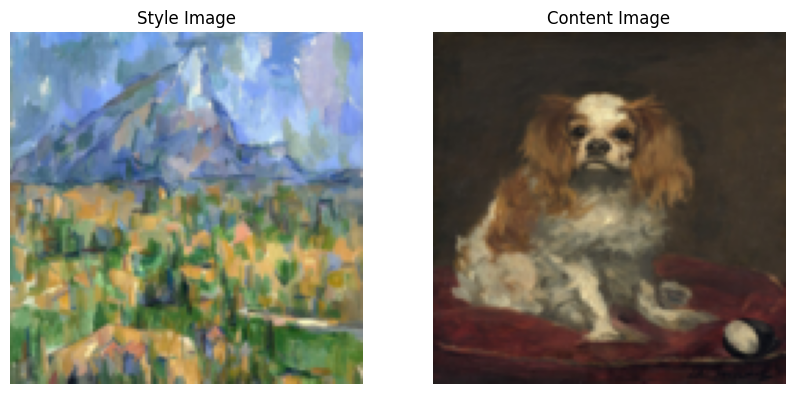

In [ ]:
# Previsualization of already processed images
to_pil = transforms.ToPILImage()

def show_image(transfomred_image, title=None):
    image = transfomred_image.cpu().clone()
    image = image.squeeze(0)
    image = to_pil(image)

    plt.imshow(image)
    if title is not None:
        plt.title(title)

def show_pil(image, title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
show_image(style_example, title="Style Image")

plt.figure()
show_image(content_example, title="Content Image")

For the example showcased in this notebook, we chose as our style image **Montaña Sainte-Victoire** of Paul Cézanne and as our content image **A king Charles Spaniel** from Edouard Manet.

# <font color= #bbc28d> **Loss Functions** </font>
A **loss function** measures how different the generated result is from the desired result.  
- Low loss → the result is close to what we want.  
- High loss → the result is far from what we want.  

In **Neural Style Transfer**, we use two loss functions:  
1. **Content loss** → measures how different the generated image is from the content image.  
2. **Style loss** → measures how different the generated image is from the style image.  

The goal is to **minimize both losses at the same time**, so the input image keeps the content of the original image while adopting the style of the other image.

## <font color= #bbc28d> **Content Loss** </font>
The **Content Loss** function is like a "score" of how well the content of the oriignal image is preserved in terms of features [like **shapes, edges,patterns,etc**]

How the function work is by comparing the **feature maps** of the generated image with those of the content image at certain layers of the NN. [We will talk about this a bit later]
- The difference is calculated using **mean squared error (MSE)**. Smaller values mean the content is well preserved.  

**NOTE**: Feature maps act like a "snapshot" of what a neural network sees at a certain layer, early layers detect **edges, lines and simple shapes**, while upper layers detect **textures, patterns and big objects**.

In PyTorch, we implement this as a **content loss module**:  
- We place it **after the convolution layer** we want to monitor.  
- Each time the network processes an image, it calculates the content loss automatically.  
- The module returns the input image so the network can continue running while keeping track of the loss.

In [ ]:
# Content Loss
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## <font color= #bbc28d> **Style Loss** </font>
Style loss is like a "score" that measures how well the **textures and patterns** of the generated image match the style image.

- Unlike content loss, it **doesn’t care about exact positions** of features.  
- Instead, it measures **which patterns appear together** by looking at **how feature maps correlate**.  
- This correlation is captured using the **Gram matrix**, which is why it’s central to style loss.

#### <font color= #bbc28d> **Gram Matrix** </font>
**Step 1**: Extract feature maps
- Pass the generated image through the network.
- Collect the **feature maps** at the chosen **style layers**.  

**Step 2**: Compute the Gram matrix
- Flatten the feature maps and multiply the matrix by its transpose → **Gram matrix**.  
- The Gram matrix shows **how patterns appear together** in the image.

**Step 3**: Normalize
- Divide each element by the total number of elements to balance contributions from different layers.

**Step 4**: Compute style loss
- Compare the Gram matrix of the generated image with that of the style image using **mean squared error (MSE)**.  
- The network updates the generated image to reduce this loss.

In [ ]:
# Style Loss
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a*b, c*d)

    G = torch.mm(features, features.t())

    return G.div(a*b*c*d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# <font color= #bbc28d> **Gradient Descent** </font>
Usually, we use **Gradient Descent** to update the NN weights, however, since we are working with a pre-trained CNN we will treat the input/generated image as a variable and update it's pixels to reduce the loss.

1. The **Input image** is passed through the network.
2. **Content loss** and **style loss** are computed by comparing its feature maps to the content and style images.
3. The **total loss** = content loss + style loss.
4. **Gradient descent** computes how to **change each pixel** of the generated image to reduce the total loss.

In [ ]:
# Create an optimizer that will update the pixels of the input image 
def get_input_optimizer(input_image):
    optimizer = optim.LBFGS([input_image])
    return optimizer

# <font color= #bbc28d> **Model Import** </font>

We're using a `Convolutional Neural Network` to apply the style transfer, which has been `trained previously to decrease computational costs`. By importing the model and weights of another model, the time and resources spent training are reduced significantly, and we're able to achieve better results.

Thus, we imported the `VGG-19 model`, an architecture developed at Oxford University in 2014. VGG-19 is characterized by its depth and simplicity, consisting of `19 layers and a uniform architecture of 3x3 convolutional filters throughout the network`. Additionally, it contains approximately `143 million parameters`. VGG-19 is `specialized in computer vision tasks`, such as the one posed in this notebook.

Although there are more modern CNN arquitectures, such as RestNet and MobileNet, we chose to use VGG-19 because it's a `great benchmark model` that continues to be used to this day.

PyTorch’s implementation of VGG is a module divided into two child `Sequential` modules: **features** (containing convolution and pooling layers), and **classifier** (containing fully connected layers). We will use the **features module** because we need the output of the individual convolution layers **to measure content and style loss**. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [ ]:
# Import model
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

# <font color= #bbc28d> **Image Normalization** </font>
Additionally, VGG networks are trained on images with each channel normalized by **mean=[0.485, 0.456, 0.406]** and **std=[0.229, 0.224, 0.225]**. We will use them to normalize the image before sending it into the network:

In [143]:
# Especificaciones del modelo específico
mean_standard = torch.tensor([0.485, 0.456, 0.406])
std_standard = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# <font color= #bbc28d> **Texture & Patterns** </font>
The **style layers** determine **which textures and patterns** the network will try to capture from the style image.  

- **Early layers** (like `conv_1`, `conv_2`) capture **basic textures** such as edges, colors, and simple shapes.  
- **Deeper layers** (like `conv_4`, `conv_5`) capture **more complex patterns and abstract textures**.  

By changing which layers are used in `TEXTURE_TEMPLATES`, we can control the **type of texture the generated image emphasizes**:  
- Using only early layers → captures **fine, simple textures**.  
- Using deeper layers → captures **bold, high-level patterns**.  
- Combining layers → mixes **fine details and larger style patterns**.  

In [ ]:
TEXTURE_TEMPLATES = {
    "default": ['conv_1','conv_2','conv_3','conv_4','conv_5'],
    "smooth_1": ['conv_1','conv_2','conv_3','conv_4','conv_5', 'relu_1'],
    "smooth_2": ['conv_1','conv_2','conv_3','conv_4','conv_5', 'relu_1', 'relu_2'],
    "efecto_fino": ['conv_1', 'conv_2'],
    "contraste_fino":['conv1_1', 'relu1_1', 'conv2_1'],
    "enfoque_texturas" : ['conv_4','conv_5']
    }

# <font color= #bbc28d> **Color Palettes** </font>
In addition to textures and patterns, we can also control the **color palette** of the generated image. While the style layers around **conv_2 and conv_3** capture much of the color information, we give the user the option to **choose which color palette to apply** after the style transfer is done.

The `transfer_color` function works as follows:

1. Convert the content, style, and generated images to **YUV color space** (which separates brightness from color).  
2. Depending on the selected mode:
   - `"content"` → keep the **colors of the content image**.  
   - `"style"` → use the **colors of the style image**.  
   - `"original"` → leave the generated image **unchanged**.  
3. Convert the image back to RGB and return it as a PIL image.  

This way, users can independently control the **color palette** without affecting the style textures.


In [ ]:
# Color transfer

def tensor_to_pil(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = to_pil(image)
    return image

def transfer_color(content_image, style_image, output_image, mode):
    content = np.array(content_image.convert('RGB'), dtype=np.uint8) 
    style = np.array(style_image.convert('RGB'), dtype=np.uint8)
    output = np.array(output_image.convert('RGB'), dtype=np.uint8)

    # Converting to YUV (PAL Color Standard)
    yuv_content = cv2.cvtColor(content, cv2.COLOR_RGB2YUV)
    yuv_style = cv2.cvtColor(style, cv2.COLOR_RGB2YUV)
    yuv_output = cv2.cvtColor(output, cv2.COLOR_RGB2YUV)

    # Color selection
    # Cotent color palette
    if mode == "content":
        yuv_output[:,:,1:] = yuv_content[:,:,1:]
    
    elif mode == "original":
        
        # Returns the normal image
        return output_image
        
    else:
        # Style color palette
        yuv_output[:,:,1:] = yuv_style[:,:,1:]
    
    final_image = cv2.cvtColor(yuv_output, cv2.COLOR_YUV2RGB)
    
    return Image.fromarray(np.uint8(final_image))

# <font color= #bbc28d> **Content and Style Feature Extraction** </font>
This function transforms a pretrained CNN into a feature extractor that can evaluate how “stylish” and “accurate” our input image is.
When we later feed an image through it during training, it will automatically compute how far the image is from the desired style and content, using gradient descent to update the pixels accordingly.

The steps it follows are:

#### 1. **Normalization**:
- Before passing images through the CNN, we normalize them using the same mean and standard deviation the original network was trained with.

#### 2. **Rebuild the CNN layer by layer**:
- We copy each layer (convolution, ReLU, pooling, etc.) from the pre-trained CNN and rename them ("conv_1", "relu_1", etc.) as we rebuild the model step by step.

#### 3. **Content Loss**:
- We send the content image through the network to capture how it looks at a certain layer. That snapshot becomes our reference. Then, we add a ContentLoss layer that checks if the generated image keeps the same structure as that reference.
- The snapshot will be done on the **4th Convolusional Layer**.

#### 4. **Style Loss**:
- We pass the style image through the network to capture its patterns at a certain layer. These feature maps are saved as a reference for the style. Then, a StyleLoss layer is added to compare the generated image’s patterns to this reference, helping the final image adopt the style’s textures and colors.

#### 5. **Return the params**
- After inserting all the required loss layers, we remove the deeper layers of the CNN, since they’re no longer needed for computing the losses.
- Returns the new CNN that has a list of both content & style loss layers.

In [ ]:
# Style and content losses

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content, 
                               style_layers, content_layers=['conv_4'], ):
    
    #1. Normalización
    normalization = Normalization(normalization_mean, normalization_std)
    # Modelo de normalización
    model = nn.Sequential(normalization)

    #Losses
    content_losses = []
    style_losses = []

    i = 0 # Para las diferentes tipos de capas conv
    
    #2. Rebuild the CNN
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        else:
            raise RuntimeError("No se reconoce una capa")
        
        model.add_module(name, layer)

        if name in content_layers:
            # 3. Content Loss
            target = model(content).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # 4. Style Loss
            target = model(style).detach()
            style_loss = StyleLoss(target)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
    
    #5 Return the new model
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]

    return model, style_losses, content_losses

Let's create a copy and remeber what our content image looks like:

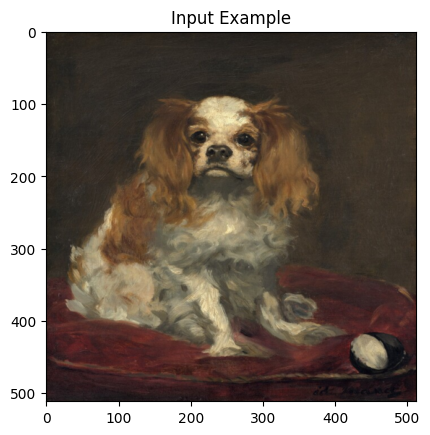

In [ ]:
# Input image -> Content Clone
input_example = content_example.clone()

plt.figure()
show_image(input_example, title="Input Example")

# <font color= #bbc28d> **Content and Style Feature Extraction** </font>
This is where everything comes together. The pre-trained CNN, the content and style feature references, and the loss layers all work together to **update the pixels of the generated image**.  

Over a number of steps, the generated image is repeatedly passed through the network, the **content and style losses** are computed, and **gradient descent** adjusts the pixels to reduce the total loss. Gradually, the image becomes a blend of the **content structure** and the **style textures**.

At the end, the function **returns the final generated image**, which has been optimized to combine the content of the original image with the style of the reference image.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content, style, input, style_layers, num_steps=300,
                       style_weight = 1e6, content_weight = 1, ):
    
    # Build the modified CNN with ContentLoss and StyleLoss layers
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content, style_layers=style_layers)

    # Treat the generated image as a variable so that we can modify it's pixels
    input.requires_grad_(True)
    model.train()

    # Freeze the model's weights
    for i in model.parameters():
        i.requires_grad_(False)

    # how to change each pixel to reduce the total loss.
    optimizer = get_input_optimizer(input)

    run = [0]

    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward(retain_graph=True)

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'Run {run[0]}')
                print(f'Style Loss: {style_score:4f}. Content Loss: {content_score:4f}')

                return style_score + content_score
            
            return loss
            
        optimizer.step(closure)

    with torch.no_grad():
        input.clamp_(0, 1)
    
    return input

# <font color= #bbc28d> **YAY: Let´s test our Model** </font>
We fianlly added all of the model's components and it's finally time to try it out:

c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Run 50
Style Loss: 1395.294189. Content Loss: 16.732012
Run 100
Style Loss: 78.363976. Content Loss: 12.748564
Run 150
Style Loss: 24.221958. Content Loss: 11.736819
Run 200
Style Loss: 8.441753. Content Loss: 10.098933
Run 250
Style Loss: 3.140698. Content Loss: 8.680593
Run 300
Style Loss: 1.556210. Content Loss: 7.550523


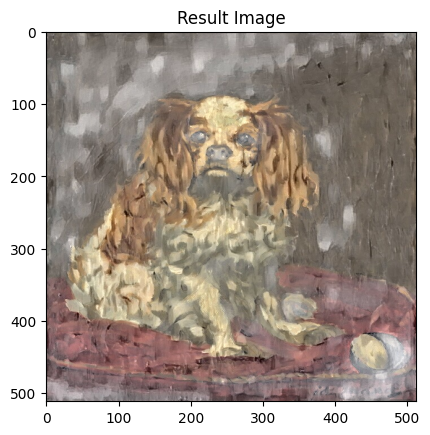

In [151]:
model_output = run_style_transfer(cnn, mean_standard, std_standard, content_example, style_example, input_example, style_layers=TEXTURE_TEMPLATES['default'])

content_pil = tensor_to_pil(content_example)
style_pil = tensor_to_pil(style_example)
output_pil = tensor_to_pil(model_output)

final_image = transfer_color(content_pil, style_pil, output_pil, mode="content")

plt.figure()
show_pil(final_image, title="Result Image")

# <font color= #bbc28d> **Model Control** </font>

In [ ]:
def image_style_transfer(content_img, style_img, style_percent, color, texture):
    
    # Cargando imagenes
    content_image = image_loader(content_img)
    style_image = image_loader(style_img)
    input_image = content_image.clone()

    model_output = run_style_transfer(cnn, mean_standard, std_standard, content_image, style_image, 
                                      input_image, style_layers=TEXTURE_TEMPLATES[texture], num_steps=300, style_weight=style_percent * 10000, content_weight=1)

    content_pil = tensor_to_pil(content_image)
    style_pil = tensor_to_pil(style_image)
    output_pil = tensor_to_pil(model_output)

    final_image = transfer_color(content_pil, style_pil, output_pil, mode=color)

    return final_image

demo = gr.Interface(image_style_transfer, inputs=[gr.Image(type='filepath'),
                                                  gr.Image(type='filepath'), 
                                                  gr.Slider(0, 100 ,label="Estilo", info="Cuánto estilo le quieres meter a la imagen?", value=100),
                                                  gr.Radio(["content",'style'], label="Color", info="Quieres el color del estilo (style) o mantener el original (content)?"),
                                                  gr.Radio(['default', 'smooth_1', 'smooth_2', 'efecto_fino', 'contraste_fino', 'enfoque_texturas'], label="Textura", info="Decide entre 6 configuraciones de textura/efectos")],
                    outputs= ["image"])
demo.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\fastapi\applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise

Run 50
Style Loss: 219.780930. Content Loss: 14.150992
Run 100
Style Loss: 68.744713. Content Loss: 12.579638
Run 150
Style Loss: 21.503147. Content Loss: 11.560948
Run 200
Style Loss: 7.996405. Content Loss: 10.096228
Run 250
Style Loss: 2.967286. Content Loss: 8.606508
Run 300
Style Loss: 1.483934. Content Loss: 7.461575


# <font color= #bbc28d> **Bibliography** </font>

- https://www.sciencedirect.com/topics/computer-science/vgg-19-convolutional-neural-network
- https://docs.pytorch.org/tutorials/advanced/neural_style_tutorial.html